In [1]:
# Cell 1: Import các thư viện cần thiết

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

import joblib

# Một số thiết lập hiển thị
pd.set_option("display.max_columns", 100)
sns.set(style="whitegrid")

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
ohlcv = pd.read_csv("/kaggle/input/train-model-isolation-forest/OHLCV_Merge.csv")
share_out = pd.read_csv("/kaggle/input/train-model-isolation-forest/Share_outstanding.csv")

print("OHLCV_Merge shape:", ohlcv.shape)
print("Share_outstanding shape:", share_out.shape)

display(ohlcv.head())
display(share_out.head())

OHLCV_Merge shape: (700963, 9)
Share_outstanding shape: (3417, 5)


,Unnamed: 0,ticker,date,open,high,low,close,volume,exchange
0,0,AAA,2020-01-02,9.8915,10.0078,9.8139,9.8925,1112410,HOSE
1,1,AAA,2020-01-03,9.8915,10.0078,9.7751,9.8537,1193840,HOSE
2,2,AAA,2020-01-06,9.7751,9.8527,9.5423,9.5433,1823010,HOSE
3,3,AAA,2020-01-07,9.5423,9.7751,9.5423,9.6209,1730250,HOSE
4,4,AAA,2020-01-08,9.5423,9.5811,9.2320,9.3106,3128170,HOSE


,Unnamed: 0.1,Unnamed: 0,Mã,Năm,shares_outstanding
0,0,0,AAA,2020,200183831
1,1,1,AAA,2021,357000015
2,2,2,AAA,2022,352423399
3,3,3,AAA,2023,382312482
4,4,4,AAA,2024,0


In [12]:
# Cell 3: Tạo bộ feature từ OHLCV_Merge + Share_outstanding

data = ohlcv.copy()

# Chuẩn hóa kiểu dữ liệu
data['date'] = pd.to_datetime(data['date'])
data['ticker'] = data['ticker'].astype(str).str.strip().str.upper()

share_out['Mã'] = share_out['Mã'].astype(str).str.strip().str.upper()
share_out['Năm'] = pd.to_numeric(share_out['Năm'], errors='coerce').astype('Int64')

# Sắp xếp theo ticker + date
data = data.sort_values(['ticker', 'date'])

g = data.groupby('ticker')

# 1) Các feature cơ bản theo phiên
# --------------------------------

# Biên độ trong ngày / close
data['range_rel'] = (data['high'] - data['low']) / data['close']

# Vị trí close trong range [low, high]
den = (data['high'] - data['low']).replace(0, np.nan)
data['close_loc'] = (data['close'] - data['low']) / den

# Giá đóng cửa ngày trước đó
data['prev_close'] = g['close'].shift(1)

# Return 1d, 3d, 5d
data['ret_1d'] = data['close'] / data['prev_close'] - 1
data['ret_3d'] = data['close'] / g['close'].shift(3) - 1
data['ret_5d'] = data['close'] / g['close'].shift(5) - 1

# Gap mở cửa so với close hôm trước
data['gap_open'] = (data['open'] - data['prev_close']) / data['prev_close']

# Z-score volume 20 phiên
data['vol_ma20'] = g['volume'].transform(lambda x: x.rolling(20, min_periods=5).mean())
data['vol_std20'] = g['volume'].transform(lambda x: x.rolling(20, min_periods=5).std())
data['vol_z20'] = (data['volume'] - data['vol_ma20']) / data['vol_std20']

# 2) Merge shares_outstanding theo ticker + năm
# --------------------------------------------
data['year'] = data['date'].dt.year

data = data.merge(
    share_out[['Mã', 'Năm', 'shares_outstanding']],
    left_on=['ticker', 'year'],
    right_on=['Mã', 'Năm'],
    how='left'
)

# Làm sạch shares_outstanding
data['shares_outstanding'] = pd.to_numeric(data['shares_outstanding'], errors='coerce')
data.loc[data['shares_outstanding'] <= 0, 'shares_outstanding'] = np.nan

# Turnover = khối lượng / shares_outstanding
data['turnover'] = data['volume'] / data['shares_outstanding']

g2 = data.groupby('ticker')

# 3) Rolling feature 3d, 5d, 10d
# -------------------------------

# --- 3 ngày ---
data['turnover_3d'] = g2['turnover'].transform(lambda x: x.rolling(3, min_periods=1).mean())
data['range_3d'] = g2['range_rel'].transform(lambda x: x.rolling(3, min_periods=1).mean())
data['close_loc_3d'] = g2['close_loc'].transform(lambda x: x.rolling(3, min_periods=1).mean())
data['vol3_mean'] = g2['volume'].transform(lambda x: x.rolling(3, min_periods=1).mean())
data['vol3_std'] = g2['volume'].transform(lambda x: x.rolling(3, min_periods=1).std())
data['volz_3d'] = (data['volume'] - data['vol3_mean']) / data['vol3_std']

# --- 5 ngày ---
data['turnover_5d'] = g2['turnover'].transform(lambda x: x.rolling(5, min_periods=1).mean())
data['range_5d'] = g2['range_rel'].transform(lambda x: x.rolling(5, min_periods=1).mean())
data['close_loc_5d'] = g2['close_loc'].transform(lambda x: x.rolling(5, min_periods=1).mean())
data['vol5_mean'] = g2['volume'].transform(lambda x: x.rolling(5, min_periods=1).mean())
data['vol5_std'] = g2['volume'].transform(lambda x: x.rolling(5, min_periods=1).std())
data['volz_5d'] = (data['volume'] - data['vol5_mean']) / data['vol5_std']

# --- 10 ngày ---
data['turnover_10d'] = g2['turnover'].transform(lambda x: x.rolling(10, min_periods=1).mean())
data['range_10d'] = g2['range_rel'].transform(lambda x: x.rolling(10, min_periods=1).mean())
data['close_loc_10d'] = g2['close_loc'].transform(lambda x: x.rolling(10, min_periods=1).mean())
data['vol10_mean'] = g2['volume'].transform(lambda x: x.rolling(10, min_periods=1).mean())
data['vol10_std'] = g2['volume'].transform(lambda x: x.rolling(10, min_periods=1).std())
data['volz_10d'] = (data['volume'] - data['vol10_mean']) / data['vol10_std']

# Xóa cột tạm
data = data.drop(columns=['vol3_mean','vol3_std','vol5_mean','vol5_std','vol10_mean','vol10_std'])

# 4) Turnover_pct & mkt_cap_pct
# -----------------------------

# Đơn giản: turnover_pct = turnover (có thể đổi sang z-score nếu muốn)
data['turnover_pct'] = data['turnover']

# Market cap (tạm): close * shares_outstanding, rồi chuẩn hóa z-score
data['mkt_cap'] = data['close'] * data['shares_outstanding']
data['mkt_cap_pct'] = (data['mkt_cap'] - data['mkt_cap'].mean()) / data['mkt_cap'].std()

# 5) Tạo nhãn churn_flag (tạm) để đánh giá Isolation Forest
#    (Bạn có thể thay bằng logic churn_flag thực tế của backend)
data['churn_flag'] = (
    (data['vol_z20'] > 2.5) |
    (data['ret_1d'].abs() > 0.07) |
    (data['gap_open'].abs() > 0.05)
).astype(int)

# Kiểm tra cuối: các cột feature bạn muốn đã tồn tại chưa
feature_check = [
    "ret_1d","ret_3d","ret_5d",
    "range_rel","close_loc","gap_open","vol_z20",
    "turnover_3d","volz_3d","range_3d","close_loc_3d",
    "turnover_5d","volz_5d","range_5d","close_loc_5d",
    "turnover_10d","volz_10d","range_10d","close_loc_10d",
    "turnover_pct","mkt_cap_pct","churn_flag"
]

data[feature_check]

,ret_1d,ret_3d,ret_5d,range_rel,close_loc,gap_open,vol_z20,turnover_3d,volz_3d,range_3d,close_loc_3d,turnover_5d,volz_5d,range_5d,close_loc_5d,turnover_10d,volz_10d,range_10d,close_loc_10d,turnover_pct,mkt_cap_pct,churn_flag
0,NaN,NaN,NaN,0.019601,0.405364,NaN,NaN,0.005557,NaN,0.019601,0.405364,0.005557,NaN,0.019601,0.405364,0.005557,NaN,0.019601,0.405364,0.005557,-0.185072,0
1,-0.003922,NaN,NaN,0.023615,0.337774,-0.000101,NaN,0.005760,0.707107,0.021608,0.371569,0.005760,0.707107,0.021608,0.371569,0.005760,0.707107,0.021608,0.371569,0.005964,-0.185360,0
2,-0.031501,NaN,NaN,0.032525,0.003222,-0.007977,NaN,0.006876,1.148355,0.025247,0.248786,0.006876,1.148355,0.025247,0.248786,0.006876,1.148355,0.025247,0.248786,0.009107,-0.187663,0
3,0.008131,-0.027455,NaN,0.024197,0.337629,-0.000105,NaN,0.007905,0.435392,0.026779,0.226208,0.007318,0.730067,0.024985,0.270997,0.007318,0.730067,0.024985,0.270997,0.008643,-0.187087,0
4,-0.032253,-0.055116,NaN,0.037495,0.225150,-0.008170,1.647407,0.011125,1.152666,0.031406,0.188667,0.008979,1.647407,0.027487,0.261828,0.008979,1.647407,0.027487,0.261828,0.015626,-0.189390,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700958,0.069122,0.221050,0.393387,0.043099,1.002520,0.022928,-0.774486,0.040063,-0.838848,0.052132,1.001700,0.049565,-0.941545,0.054059,1.001020,0.036897,-0.717848,0.056987,0.779534,0.017706,-0.150946,0
700959,-0.068965,0.064039,0.213479,0.148131,0.000719,0.066698,0.490426,0.045197,0.120132,0.087553,0.667746,0.039422,0.442789,0.073010,0.801164,0.039038,0.347946,0.064189,0.779467,0.048329,-0.158363,1
700960,-0.069442,-0.073732,0.057896,0.000000,NaN,-0.069442,-1.393867,0.023106,-0.861745,0.063743,0.501620,0.034360,-1.200807,0.060905,0.751454,0.036262,-1.138284,0.058746,0.810519,0.003283,-0.165315,1
700961,-0.004977,-0.137929,-0.014778,0.109998,0.590916,-0.069653,2.098920,0.049173,1.008987,0.086043,0.295817,0.046956,1.299952,0.074531,0.648539,0.042756,1.544195,0.062555,0.844264,0.095907,-0.165779,1


In [13]:
feature_cols = [
    "ret_1d","ret_3d","ret_5d",
    "range_rel","close_loc","gap_open","vol_z20",
    "turnover_3d","volz_3d","range_3d","close_loc_3d",
    "turnover_5d","volz_5d","range_5d","close_loc_5d",
    "turnover_10d","volz_10d","range_10d","close_loc_10d",
    "turnover_pct","mkt_cap_pct"
]

label_col = "churn_flag"

# Giữ lại những dòng đủ dữ liệu
df_model = data.dropna(subset=feature_cols + [label_col]).copy()

X = df_model[feature_cols]
y = df_model[label_col].astype(int)

print("Kích thước tập train (sau dropna):", X.shape)
print("Tỷ lệ label:")
print(y.value_counts(normalize=True))

Kích thước tập train (sau dropna): (571805, 21)
Tỷ lệ label:
churn_flag
0    0.864725
1    0.135275
Name: proportion, dtype: float64


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train.shape, X_test.shape

((457444, 21), (114361, 21))

In [15]:
iso = IsolationForest(
    n_estimators=200,
    max_samples='auto',
    contamination=0.02,   # tỷ lệ ước lượng giao dịch bất thường
    random_state=42,
    n_jobs=-1
)

iso.fit(X_train_scaled)

print("✅ Isolation Forest đã train xong.")

✅ Isolation Forest đã train xong.


=== Classification Report ===
              precision    recall  f1-score   support

           0     0.8748    0.9913    0.9294     98891
           1     0.6260    0.0928    0.1617     15470

    accuracy                         0.8698    114361
   macro avg     0.7504    0.5421    0.5455    114361
weighted avg     0.8411    0.8698    0.8256    114361



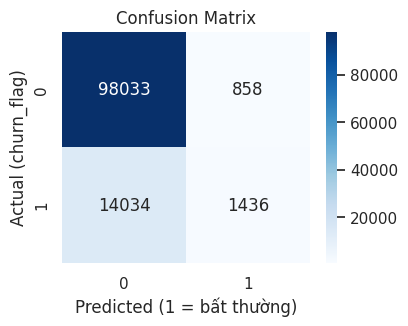

ROC-AUC: 0.8754


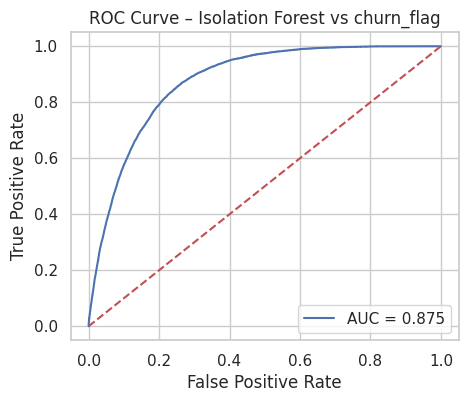

In [16]:
raw_pred_test = iso.predict(X_test_scaled)

# Đổi về format 0/1: 1 = bất thường
y_pred_test = (raw_pred_test == -1).astype(int)

# Anomaly score: càng lớn càng bất thường
anomaly_score_test = -iso.decision_function(X_test_scaled)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred_test, digits=4))

# Ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted (1 = bất thường)")
plt.ylabel("Actual (churn_flag)")
plt.title("Confusion Matrix")
plt.show()

# ROC-AUC
roc_auc = roc_auc_score(y_test, anomaly_score_test)
print(f"ROC-AUC: {roc_auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, anomaly_score_test)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Isolation Forest vs churn_flag")
plt.legend()
plt.show()

In [17]:
feature_cols = [
    "ret_1d","ret_3d","ret_5d",
    "range_rel","close_loc","gap_open","vol_z20",
    "turnover_3d","volz_3d","range_3d","close_loc_3d",
    "turnover_5d","volz_5d","range_5d","close_loc_5d",
    "turnover_10d","volz_10d","range_10d","close_loc_10d",
    "turnover_pct","mkt_cap_pct"
]
label_col = "churn_flag"

df_model = data.dropna(subset=feature_cols + [label_col]).copy()
X = df_model[feature_cols]
y = df_model[label_col].astype(int)

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((457444, 21), (114361, 21))

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    n_jobs=-1,
    random_state=42,
    class_weight='balanced_subsample'  # xử lý mất cân bằng
)

rf.fit(X_train, y_train)
print("✅ Trained RandomForest.")

✅ Trained RandomForest.


=== RandomForest – Classification Report ===
              precision    recall  f1-score   support

           0     0.9999    0.9998    0.9998     98891
           1     0.9986    0.9995    0.9990     15470

    accuracy                         0.9997    114361
   macro avg     0.9992    0.9996    0.9994    114361
weighted avg     0.9997    0.9997    0.9997    114361



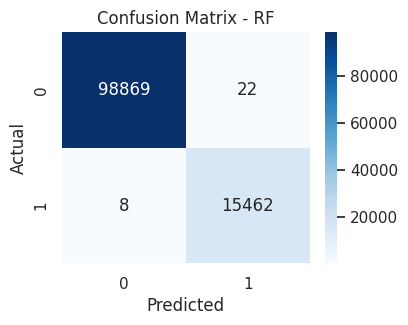

ROC-AUC: 1.0000


In [20]:
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print("=== RandomForest – Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - RF")
plt.show()

auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC: {auc:.4f}")

,feature,importance
5,gap_open,0.316733
0,ret_1d,0.135284
6,vol_z20,0.133293
3,range_rel,0.132028
16,volz_10d,0.059737
9,range_3d,0.032997
12,volz_5d,0.032449
1,ret_3d,0.025492
13,range_5d,0.017435
4,close_loc,0.016129


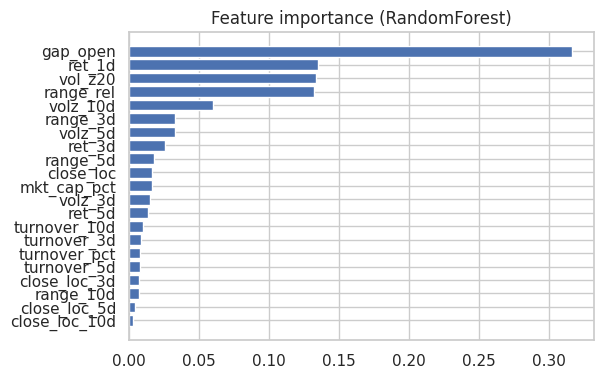

In [21]:
import numpy as np
feat_imp = pd.DataFrame({
    "feature": feature_cols,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

display(feat_imp)

plt.figure(figsize=(6,4))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.gca().invert_yaxis()
plt.title("Feature importance (RandomForest)")
plt.show()

In [23]:
# Cell 1: định nghĩa 2 nhóm feature

# Nhóm 1: các cột dùng để tạo nhãn (rule-based)
rule_features = ["vol_z20", "ret_1d", "gap_open"]

# Toàn bộ feature gốc bạn muốn dùng cho model
all_features = [
    "ret_1d","ret_3d","ret_5d",
    "range_rel","close_loc","gap_open",
    "vol_z20",
    "turnover_3d","volz_3d","range_3d","close_loc_3d",
    "turnover_5d","volz_5d","range_5d","close_loc_5d",
    "turnover_10d","volz_10d","range_10d","close_loc_10d",
    "turnover_pct","mkt_cap_pct"
]

label_col = "churn_flag"

# Nhóm 2: feature hành vi = all_features trừ đi rule_features
behavior_features = [f for f in all_features if f not in rule_features]

print("Rule features:", rule_features)
print("Behavior features:", behavior_features)
print("Số feature hành vi:", len(behavior_features))

Rule features: ['vol_z20', 'ret_1d', 'gap_open']
Behavior features: ['ret_3d', 'ret_5d', 'range_rel', 'close_loc', 'turnover_3d', 'volz_3d', 'range_3d', 'close_loc_3d', 'turnover_5d', 'volz_5d', 'range_5d', 'close_loc_5d', 'turnover_10d', 'volz_10d', 'range_10d', 'close_loc_10d', 'turnover_pct', 'mkt_cap_pct']
Số feature hành vi: 18


In [24]:
# Cell 2: chuẩn bị dữ liệu huấn luyện chỉ với feature hành vi

# data lúc trước bạn đã tạo từ OHLCV + share_out + feature engineering
df_model = data.dropna(subset=behavior_features + [label_col]).copy()

X = df_model[behavior_features]
y = df_model[label_col].astype(int)

print("Shape X, y:", X.shape, y.shape)
print("Tỷ lệ nhãn:")
print(y.value_counts(normalize=True))


Shape X, y: (571805, 18) (571805,)
Tỷ lệ nhãn:
churn_flag
0    0.864725
1    0.135275
Name: proportion, dtype: float64


In [29]:
# Cell 3: train/test split + train RF

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

rf_behav = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced_subsample"
)

rf_behav.fit(X_train, y_train)
print("✅ Trained RF on behavior-only features.")


✅ Trained RF on behavior-only features.


=== RandomForest (behavior-only) ===
              precision    recall  f1-score   support

           0     0.9282    0.9766    0.9518     98891
           1     0.7753    0.5169    0.6203     15470

    accuracy                         0.9144    114361
   macro avg     0.8517    0.7467    0.7860    114361
weighted avg     0.9075    0.9144    0.9069    114361



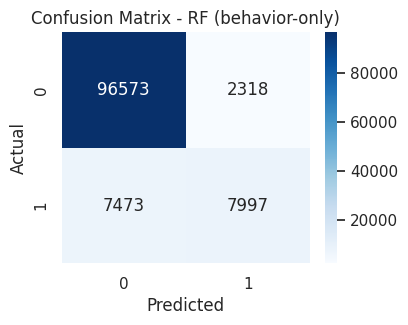

ROC-AUC: 0.9464


In [30]:
# Cell 4: đánh giá mô hình hành vi

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = rf_behav.predict(X_test)
y_prob = rf_behav.predict_proba(X_test)[:, 1]

print("=== RandomForest (behavior-only) ===")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - RF (behavior-only)")
plt.show()

auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC: {auc:.4f}")


In [27]:
# Cell 5: feature importance để biết hành vi nào giúp phân biệt nhiều nhất

import pandas as pd

feat_imp = pd.DataFrame({
    "feature": behavior_features,
    "importance": rf_behav.feature_importances_
}).sort_values("importance", ascending=False)

display(feat_imp.head(15))


,feature,importance
2,range_rel,0.183544
13,volz_10d,0.130068
0,ret_3d,0.077695
6,range_3d,0.071958
9,volz_5d,0.071127
17,mkt_cap_pct,0.055842
10,range_5d,0.046837
1,ret_5d,0.045624
5,volz_3d,0.042161
12,turnover_10d,0.036269


In [1]:
# Cell 1: Import thư viện & config

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

sns.set(style="whitegrid")
pd.set_option("display.max_columns", 120)

# Config giống backend
PRICE_UNIT  = 1.0      # nếu dữ liệu giá đang là đơn vị chuẩn
CONTAM      = 0.02
RANDOM_SEED = 42

# Sử dụng đúng list FEATURES trong backend
FEATURES = [
    "ret_1d","ret_3d","ret_5d",
    "range_rel","close_loc","gap_open","vol_z20",
    "turnover_3d","volz_3d","range_3d","close_loc_3d",
    "turnover_5d","volz_5d","range_5d","close_loc_5d",
    "turnover_10d","volz_10d","range_10d","close_loc_10d",
    "turnover_pct","mkt_cap_pct","churn_flag"
]

In [2]:
# Cell 2: Hàm chuẩn hoá cột & rolling z-score (copy logic từ backend)

def _standardize_cols(df: pd.DataFrame) -> pd.DataFrame:
    """Chuẩn hoá tên cột phổ biến (giống risk_engine.py)."""
    if df is None:
        return df
    mapping = {}
    low = {c.lower().strip(): c for c in df.columns}
    
    def pick(names):
        for n in names:
            if n in low:
                return low[n]
        for n in names:
            for k in low:
                if n in k:
                    return low[k]
        return None

    # OHLCV
    if pick(["ticker","mã","ma","symbol"]):
        mapping[pick(["ticker","mã","ma","symbol"])] = "ticker"
    if pick(["date","ngày","trading_date"]):
        mapping[pick(["date","ngày","trading_date"])] = "date"
    if pick(["open","giá mở"]):
        mapping[pick(["open","giá mở"])] = "open"
    if pick(["high","cao nhất"]):
        mapping[pick(["high","cao nhất"])] = "high"
    if pick(["low","thấp nhất"]):
        mapping[pick(["low","thấp nhất"])] = "low"
    if pick(["close","đóng cửa"]):
        mapping[pick(["close","đóng cửa"])] = "close"
    if pick(["volume","khối lượng","vol"]):
        mapping[pick(["volume","khối lượng","vol"])] = "volume"
    if pick(["exchange","sàn"]):
        mapping[pick(["exchange","sàn"])] = "exchange"

    # shares theo năm
    if pick(["năm","year"]):
        mapping[pick(["năm","year"])] = "year"
    if "Mã" in df.columns and "ticker" not in mapping:
        mapping["Mã"] = "ticker"
    if "Năm" in df.columns and "year" not in mapping:
        mapping["Năm"] = "year"
    if "shares_outstanding" in df.columns:
        mapping["shares_outstanding"] = "shares_outstanding"

    return df.rename(columns=mapping)


def _zscore_rolling(s: pd.Series, win: int) -> pd.Series:
    m = s.rolling(win, min_periods=max(5, win//3)).mean()
    sd = s.rolling(win, min_periods=max(5, win//3)).std()
    return (s - m) / sd


In [4]:
# Cell 3: Load data & tạo toàn bộ feature giống backend

# TODO: thay "your-dataset-name" bằng tên folder dataset trên Kaggle
ohlcv_path  = "/kaggle/input/train-model-isolation-forest/OHLCV_Merge.csv"
shares_path = "/kaggle/input/train-model-isolation-forest/Share_outstanding.csv"

o = pd.read_csv(ohlcv_path)
s = pd.read_csv(shares_path)

# Xoá cột index thừa nếu có
for col in ["Unnamed: 0", "Unnamed: 0.1"]:
    if col in o.columns:
        o = o.drop(columns=[col])
    if col in s.columns:
        s = s.drop(columns=[col])

# Chuẩn hoá tên cột
o = _standardize_cols(o)
s = _standardize_cols(s)

# Chuẩn hoá dữ liệu OHLCV
o["ticker"] = o["ticker"].astype(str).str.upper().str.strip()
o["date"]   = pd.to_datetime(o["date"])
o["year"]   = o["date"].dt.year

for c in ["open","high","low","close","volume"]:
    if c in o.columns:
        o[c] = pd.to_numeric(o[c], errors="coerce")
o["close"] = o["close"] * PRICE_UNIT
o = o.sort_values(["ticker","date"]).reset_index(drop=True)

# Chuẩn hoá Shares
s["ticker"] = s["ticker"].astype(str).str.upper().str.strip()
s["year"]   = pd.to_numeric(s["year"], errors="coerce").astype("Int64")

if "shares_outstanding" in s.columns:
    s["shares_outstanding"] = pd.to_numeric(s["shares_outstanding"], errors="coerce")
    # 0 hoặc âm coi như thiếu
    s.loc[s["shares_outstanding"] <= 0, "shares_outstanding"] = np.nan

# Merge theo ticker-year
df = o.merge(
    s[["ticker", "year", "shares_outstanding"]],
    on=["ticker","year"],
    how="left"
)

# ffill/bfill shares theo từng ticker (giống backend)
df_sorted = df.sort_values(["ticker", "year"])
df["shares_outstanding"] = (
    df_sorted.groupby("ticker")["shares_outstanding"]
    .transform(lambda x: x.ffill().bfill())
)

# Loại các dòng thiếu thông tin cơ bản
df = df.dropna(subset=["close", "volume", "shares_outstanding"]).copy()

# ========== Feature engineering y chang backend ==========
g = df.groupby("ticker", group_keys=False)

df["ret_1d"] = g["close"].pct_change(1)
df["ret_3d"] = g["close"].pct_change(3)
df["ret_5d"] = g["close"].pct_change(5)

df["range_rel"] = (df["high"] - df["low"]) / g["close"].shift(1)
df["close_loc"] = (df["close"] - (df["high"] + df["low"]) / 2) / \
                  (df["high"] - df["low"]).replace(0, np.nan)

df["gap_open"]  = (df["open"] - g["close"].shift(1)) / g["close"].shift(1)

df["vol_z20"]   = g["volume"].apply(lambda s: _zscore_rolling(s, 20))

df["turnover"]  = df["volume"] / df["shares_outstanding"]
df["mkt_cap"]   = df["close"]  * df["shares_outstanding"]

for w in (3, 5, 10):
    df[f"turnover_{w}d"]  = g["turnover"].apply(lambda s: s.rolling(w, min_periods=max(2, w//2)).mean())
    df[f"volz_{w}d"]      = g["vol_z20"].apply(lambda s: s.rolling(w, min_periods=max(2, w//2)).mean())
    df[f"range_{w}d"]     = g["range_rel"].apply(lambda s: s.rolling(w, min_periods=max(2, w//2)).mean())
    df[f"close_loc_{w}d"] = g["close_loc"].apply(lambda s: s.rolling(w, min_periods=max(2, w//2)).mean())

# cờ churn_flag: KL đột biến nhưng biên độ hẹp (đúng rule backend)
df["churn_flag"] = ((df["vol_z20"] > 2.0) & (df["range_rel"].abs() < 0.01)).astype(int)

# chuẩn hoá chéo theo ngày
df["turnover_pct"] = df.groupby("date")["turnover"].rank(pct=True)
df["mkt_cap_pct"]  = df.groupby("date")["mkt_cap"].rank(pct=True)

print("Shape sau feature engineering:", df.shape)
df[FEATURES]


Shape sau feature engineering: (687710, 34)


,ret_1d,ret_3d,ret_5d,range_rel,close_loc,gap_open,vol_z20,turnover_3d,volz_3d,range_3d,close_loc_3d,turnover_5d,volz_5d,range_5d,close_loc_5d,turnover_10d,volz_10d,range_10d,close_loc_10d,turnover_pct,mkt_cap_pct,churn_flag
0,NaN,NaN,NaN,NaN,-0.094636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.923434,0.814385,0
1,-0.003922,NaN,NaN,0.023523,-0.162226,-0.000101,NaN,0.005760,NaN,NaN,-0.128431,0.005760,NaN,NaN,-0.128431,NaN,NaN,NaN,NaN,0.932280,0.819413,0
2,-0.031501,NaN,NaN,0.031501,-0.496778,-0.007977,NaN,0.006876,NaN,0.027512,-0.251214,0.006876,NaN,0.027512,-0.251214,NaN,NaN,NaN,NaN,0.966102,0.801453,0
3,0.008131,-0.027455,NaN,0.024394,-0.162371,-0.000105,NaN,0.007905,NaN,0.026473,-0.273792,0.007318,NaN,0.026473,-0.229003,NaN,NaN,NaN,NaN,0.957746,0.812207,0
4,-0.032253,-0.055116,NaN,0.036286,-0.274850,-0.008170,NaN,0.011125,NaN,0.030727,-0.311333,0.008979,NaN,0.028926,-0.238172,0.008979,NaN,NaN,-0.238172,0.985680,0.806683,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700958,0.069122,0.221050,0.393387,0.046078,0.502520,0.022928,-0.774486,0.040063,0.227152,0.055722,0.501700,0.049565,0.695326,0.057766,0.501020,0.036897,0.286140,0.059367,0.279534,0.939292,0.728499,0
700959,-0.068965,0.064039,0.213479,0.137915,-0.499281,0.066698,0.490426,0.045197,0.392468,0.086783,0.167746,0.039422,0.204340,0.073937,0.301164,0.039038,0.325818,0.065727,0.279467,0.998339,0.717608,0
700960,-0.069442,-0.073732,0.057896,0.000000,NaN,-0.069442,-1.393867,0.023106,-0.559309,0.061331,0.001620,0.034360,-0.044397,0.061016,0.251454,0.036262,0.157123,0.060191,0.310519,0.695364,0.701987,0
700961,-0.004977,-0.137929,-0.014778,0.109450,0.090916,-0.069653,2.098920,0.049173,0.398493,0.082455,-0.204183,0.046956,0.376491,0.073960,0.148539,0.042756,0.341419,0.063994,0.344264,1.000000,0.689003,0


In [5]:
# Cell 4: chọn universe train + train Isolation Forest

# Chọn blue-chips theo median turnover & mkt_cap
agg = (
    df.groupby("ticker")
      .agg(med_turn=("turnover","median"),
           med_cap =("mkt_cap","median"))
      .replace([np.inf,-np.inf], np.nan)
      .dropna()
)

thr_turn = agg["med_turn"].quantile(0.7)
thr_cap  = agg["med_cap"].quantile(0.7)
blue     = set(agg[(agg["med_turn"] >= thr_turn) & (agg["med_cap"] >= thr_cap)].index)

# train_mask: blue-chips & date < 2024-01-01
train_mask = (df["ticker"].isin(blue)) & (df["date"] < pd.Timestamp("2024-01-01"))

# Tập train theo FEATURES (giống risk_engine)
X_train = (
    df.loc[train_mask, FEATURES]
      .replace([np.inf, -np.inf], np.nan)
      .dropna()
)

print("Train shape:", X_train.shape)

scaler = RobustScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)

iso = IsolationForest(
    n_estimators=400,
    contamination=CONTAM,
    bootstrap=True,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

iso.fit(X_train_scaled)
print("✅ Isolation Forest trained.")


Train shape: (80023, 22)
✅ Isolation Forest trained.


In [6]:
# Cell 5: Score toàn bộ vũ trụ (giống backend) & tạo risk_0_10

valid_idx = (
    df[FEATURES]
      .replace([np.inf, -np.inf], np.nan)
      .dropna()
      .index
)

X_all_scaled = scaler.transform(df.loc[valid_idx, FEATURES])

# anom score: lấy dấu trừ để "càng lớn càng bất thường"
anom_raw = -iso.score_samples(X_all_scaled)

out = df.loc[valid_idx, ["date", "ticker", "exchange", "close", "volume", "turnover", "mkt_cap"]].copy()
out["anom_raw"] = anom_raw
out["anom_pct_daily"] = out.groupby("date")["anom_raw"].rank(pct=True)
out["risk_0_10"] = (out["anom_pct_daily"] * 10).clip(0, 10).round(1)

print("Scores shape:", out.shape)
out.head()


Scores shape: (575688, 10)


,date,ticker,exchange,close,volume,turnover,mkt_cap,anom_raw,anom_pct_daily,risk_0_10
9,2020-01-15,AAA,HOSE,9.2330,1635150,0.008168,1.848297e+09,0.392192,0.029740,0.3
10,2020-01-16,AAA,HOSE,9.6209,2496260,0.012470,1.925949e+09,0.418615,0.166667,1.7
11,2020-01-17,AAA,HOSE,9.6985,1558730,0.007786,1.941483e+09,0.386722,0.026490,0.3
12,2020-01-20,AAA,HOSE,9.6597,966320,0.004827,1.933716e+09,0.380742,0.003247,0.0
13,2020-01-21,AAA,HOSE,9.7373,1110960,0.005550,1.949250e+09,0.391287,0.022801,0.2


=== Classification Report (IsolationForest vs churn_flag) ===
              precision    recall  f1-score   support

           0     0.9979    0.9281    0.9617    574020
           1     0.0127    0.3183    0.0244      1668

    accuracy                         0.9263    575688
   macro avg     0.5053    0.6232    0.4931    575688
weighted avg     0.9950    0.9263    0.9590    575688



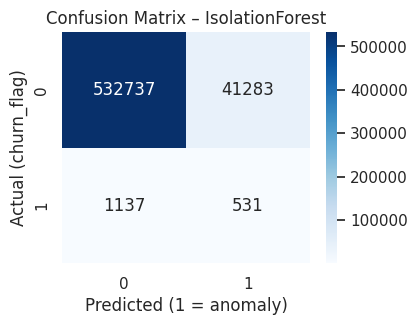

ROC-AUC: 0.8413


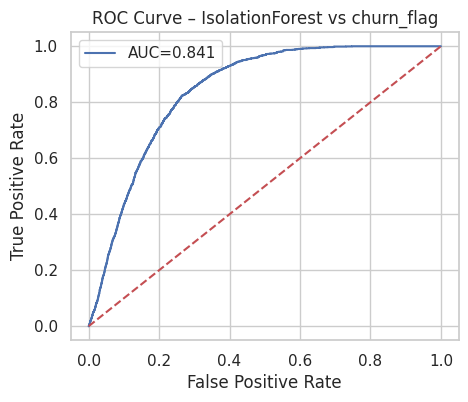

In [7]:
# Cell 6: Evaluate Isolation Forest vs churn_flag

from sklearn.metrics import precision_score, recall_score, f1_score

# Nhãn thực tế (theo rule churn_flag)
y_true = df.loc[valid_idx, "churn_flag"].astype(int).values

# Dự đoán anomaly từ IF: 1 = bất thường, 0 = bình thường
pred_iso = iso.predict(X_all_scaled)  # 1 = inlier, -1 = outlier
y_pred = (pred_iso == -1).astype(int)

print("=== Classification Report (IsolationForest vs churn_flag) ===")
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted (1 = anomaly)")
plt.ylabel("Actual (churn_flag)")
plt.title("Confusion Matrix – IsolationForest")
plt.show()

# ROC-AUC với anomaly score
roc_auc = roc_auc_score(y_true, anom_raw)
print(f"ROC-AUC: {roc_auc:.4f}")

fpr, tpr, _ = roc_curve(y_true, anom_raw)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – IsolationForest vs churn_flag")
plt.legend()
plt.show()
